In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

print(tf.__version__, np.__version__)

# Expected output 2.9.0, 1.26.4

2.9.0 1.26.4


## Detect GPU and limit GPU memory usage if exist

In [2]:
USE_GPU = True

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus != []:
    print(gpus)
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU on this machine")

# Expected output [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if USE_GPU == False:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


# Load data

In [6]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\train"
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 39703 files belonging to 2 classes.

Found 39703 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# Split Train/Val

In [10]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)

In [11]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# Build model

In [12]:
# True = Training the base model

TRAIN_FULL_NETWROK = False

In [13]:
IMG_DIM = (224,224)
INPUT_SHAPE = (224,224,3)

In [14]:
base_model = tf.keras.applications.ResNet152(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
base_model.trainable = TRAIN_FULL_NETWROK

In [16]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [17]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=TRAIN_FULL_NETWROK)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# A Dense classifier with a single unit (binary classification)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

In [18]:
import pandas as pd

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000002017C929D50>,input_2,True
1,<keras.engine.functional.Functional object at 0x000002017C8C65C0>,resnet152,False
2,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000002017C8D8A60>,global_average_pooling2d,True
3,<keras.layers.core.dense.Dense object at 0x000002014D9E8F70>,dense,True
4,<keras.layers.core.dense.Dense object at 0x00000201501E5ED0>,dense_1,True
5,<keras.layers.core.dense.Dense object at 0x00000202E92C8250>,dense_2,True


In [19]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet152 (Functional)      (None, 7, 7, 2048)        58370944  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                             

In [20]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), # change from_logits=True
              optimizer= keras.optimizers.RMSprop(learning_rate=1e-2),
              metrics = [keras.metrics.BinaryAccuracy()])

# Set up training metrics

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [22]:
dir_path = r"C:\Users\kanan\Desktop\data_x"
results_dir = os.path.join(dir_path, r'logs\ResNet152')
models_dir = os.path.join(dir_path, r'models\ResNet152')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

In [23]:
log_file = os.path.join(results_dir, 'ResNet152.csv')

In [29]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir,"ResNet152-Bestof20_lr001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

# Train model

In [30]:
EPOCH =  20

In [31]:
history = model.fit(train, 
                    validation_data=val,
                    epochs=EPOCH, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 0.4912 - binary_accuracy: 0.7709
Epoch 1: val_loss improved from inf to 0.45315, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr001.h5
992/992 [==============================] - 329s 332ms/step - loss: 0.4912 - binary_accuracy: 0.7709 - val_loss: 0.4532 - val_binary_accuracy: 0.7829
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.4572 - binary_accuracy: 0.7866
Epoch 2: val_loss did not improve from 0.45315
992/992 [==============================] - 337s 339ms/step - loss: 0.4572 - binary_accuracy: 0.7866 - val_loss: 0.4694 - val_binary_accuracy: 0.7695
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.4240 - binary_accuracy: 0.8018
Epoch 3: val_loss improved from 0.45315 to 0.39449, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr001.h5
992/992 [==============================] - 337s 340ms/step - los

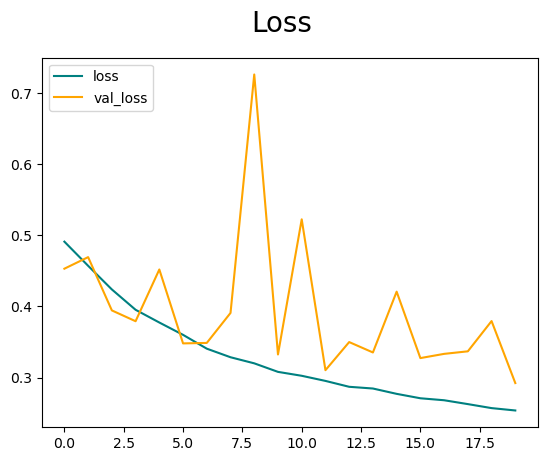

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Reducing learning rate from 0.01 to 0.001 and continue

Load model

In [33]:
from tensorflow.keras.models import load_model

saved_model_path = r"C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr001.h5"
new_model = load_model(saved_model_path)

Set new learning rate

In [34]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"Old learning rate: {current_lr}")

Old learning rate: 0.009999999776482582


In [35]:
new_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              optimizer= keras.optimizers.RMSprop(learning_rate=1e-3),
              metrics = [keras.metrics.BinaryAccuracy()])

In [36]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"New learning rate: {current_lr}")

New learning rate: 0.0010000000474974513


Continue training

In [37]:
log_file = os.path.join(results_dir, 'ResNet152_bo20_lr0001.csv')

In [38]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir,"ResNet152-Bestof20_lr0001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

In [39]:
history = new_model.fit(train, 
                    validation_data=val,
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 0.1899 - binary_accuracy: 0.9192
Epoch 1: val_loss improved from inf to 0.30227, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr0001.h5
992/992 [==============================] - 342s 337ms/step - loss: 0.1899 - binary_accuracy: 0.9192 - val_loss: 0.3023 - val_binary_accuracy: 0.8889
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.1849 - binary_accuracy: 0.9219
Epoch 2: val_loss did not improve from 0.30227
992/992 [==============================] - 338s 341ms/step - loss: 0.1849 - binary_accuracy: 0.9219 - val_loss: 0.3036 - val_binary_accuracy: 0.8906
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.1830 - binary_accuracy: 0.9227
Epoch 3: val_loss improved from 0.30227 to 0.29776, saving model to C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr0001.h5
992/992 [==============================] - 337s 340ms/step - l

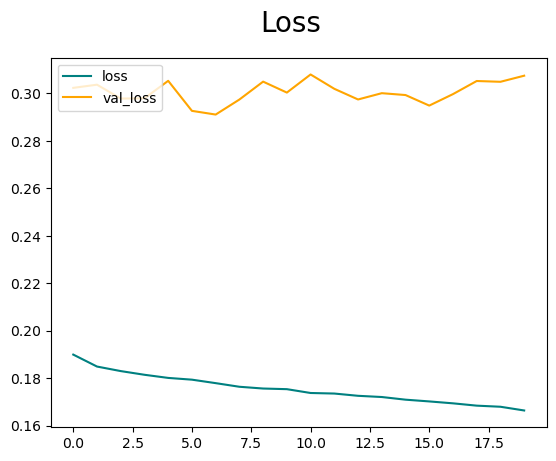

In [40]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test

Load model

In [41]:
from numpy.testing import assert_allclose
from tensorflow.keras.models import load_model

saved_model_path = r"C:\Users\kanan\Desktop\data_x\models\ResNet152\ResNet152-Bestof20_lr0001.h5"
test_model = load_model(saved_model_path)

Set measurement metrics

In [42]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

Load data

In [43]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\test"
test = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 7360 files belonging to 2 classes.

Found 7360 files belonging to 2 classes.


Testing

In [44]:
test_iterator = test.as_numpy_iterator()
batch = test_iterator.next()

In [45]:
for batch in test_iterator: 
    X, y = batch
    yhat = test_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 38ms/step


Test results

In [49]:
f1_score = 2 * (pre.result() * re.result()) / (pre.result() + re.result())
print(f"Precision : {pre.result().numpy()}")
print(f"Recall : {re.result().numpy()}")
print(f"Accuracy : {acc.result().numpy()}")
print(f"F1 Score : {f1_score.numpy()}")

Precision : 0.8533724546432495
Recall : 0.774622917175293
Accuracy : 0.77947598695755
F1 Score : 0.8120930194854736
